## Soil Moisture Forecasting

### In this project we want to forecast tomorrow soil moisture by using reading data from soil moisture sensors.

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping
from src.data.load_data import load_data_file
plt.style.use("classic")
sns.set()
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
### CONSTANTs
DATA_PATH = "../data/external/soil_moist/data_set.csv"

### Loading data from a csv file

In [60]:
data = load_data_file(DATA_PATH)

In [61]:
data.head()

,time,latitude,longitude,clay,sand,silt,soil_moist
0,2013-01-03,54.875,9.125,5,86,9,0.53
1,2013-01-05,54.875,9.125,5,86,9,0.44
2,2013-01-07,54.875,9.125,5,86,9,0.42
3,2013-01-08,54.875,9.125,5,86,9,0.55
4,2013-01-09,54.875,9.125,5,86,9,0.46


In [62]:
## Checking data set info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321584 entries, 0 to 321583
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        321584 non-null  object 
 1   latitude    321584 non-null  float64
 2   longitude   321584 non-null  float64
 3   clay        321584 non-null  int64  
 4   sand        321584 non-null  int64  
 5   silt        321584 non-null  int64  
 6   soil_moist  321584 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 17.2+ MB


#### Checking Missing data

In [63]:
data.isna().any()

time          False
latitude      False
longitude     False
clay          False
sand          False
silt          False
soil_moist    False
dtype: bool

#### Descriptive Analysis

In [64]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,321584.0,50.840357,1.646484,48.125,49.375,50.875,52.125,54.875
longitude,321584.0,9.622973,3.789899,2.125,6.625,9.875,12.875,15.875
clay,321584.0,20.887920,7.922680,4.000,13.000,22.000,27.000,46.000
sand,321584.0,39.242963,21.846045,6.000,22.000,32.000,61.000,86.000
silt,321584.0,39.894503,15.229785,8.000,25.000,44.000,51.000,72.000
soil_moist,321584.0,0.411891,0.110530,0.010,0.350,0.420,0.490,0.600


### EDA
1. Data needs to be categorized based on the locations (lat and long)

In [65]:
gr_data = data.groupby(["latitude","longitude"])["soil_moist"].value_counts()


#### Define a new feature:
 sensors data are belonged to different locations, so we need to define a new features to identify each location. (classify them by their lat and lon)

In [66]:
### Creating location id for each unique location
unique_df = data.drop_duplicates(subset=["latitude","longitude"])
unique_df.reset_index(inplace=True)
data['loc'] = np.nan
for idx, row in unique_df.iterrows():
    data.loc[(data["latitude"]==row["latitude"]) & (data["longitude"] == row["longitude"]),'loc'] = idx+1 


In [67]:
data['loc'].nunique()

1166

#### Result : There are 1166 different locations in the data set

In [68]:
### sorting data by the number of samples for each location
data["loc"].value_counts().sort_values(ascending=False).head()


loc
321.0    359
281.0    358
276.0    358
322.0    358
194.0    357
Name: count, dtype: int64

### Univariate Analysis

In [69]:
### choosing 10 random location and plot 

number_of_locs = 4
rand_loc_ids = random.sample(range(1, data['loc'].nunique() + 1), number_of_locs)
fig = px.line()
for lc in rand_loc_ids:
    loc_data = data[data["loc"]==lc]
    fig.add_scatter(x=loc_data['time'], y = loc_data['soil_moist'], \
        mode = 'lines', name = f"location: {lc}")
fig.update_layout(title='Comparison of soil moistures', xaxis_title='Time Stamps', yaxis_title='Soil Moisture')

fig.show()
    
    



### Analysis:
by plotting moisture for different locations (only one) or more than one location, it seems that time series are stationary, and we can not see any seasonality or trend component in them

### Soil Moisture distribution Analysis

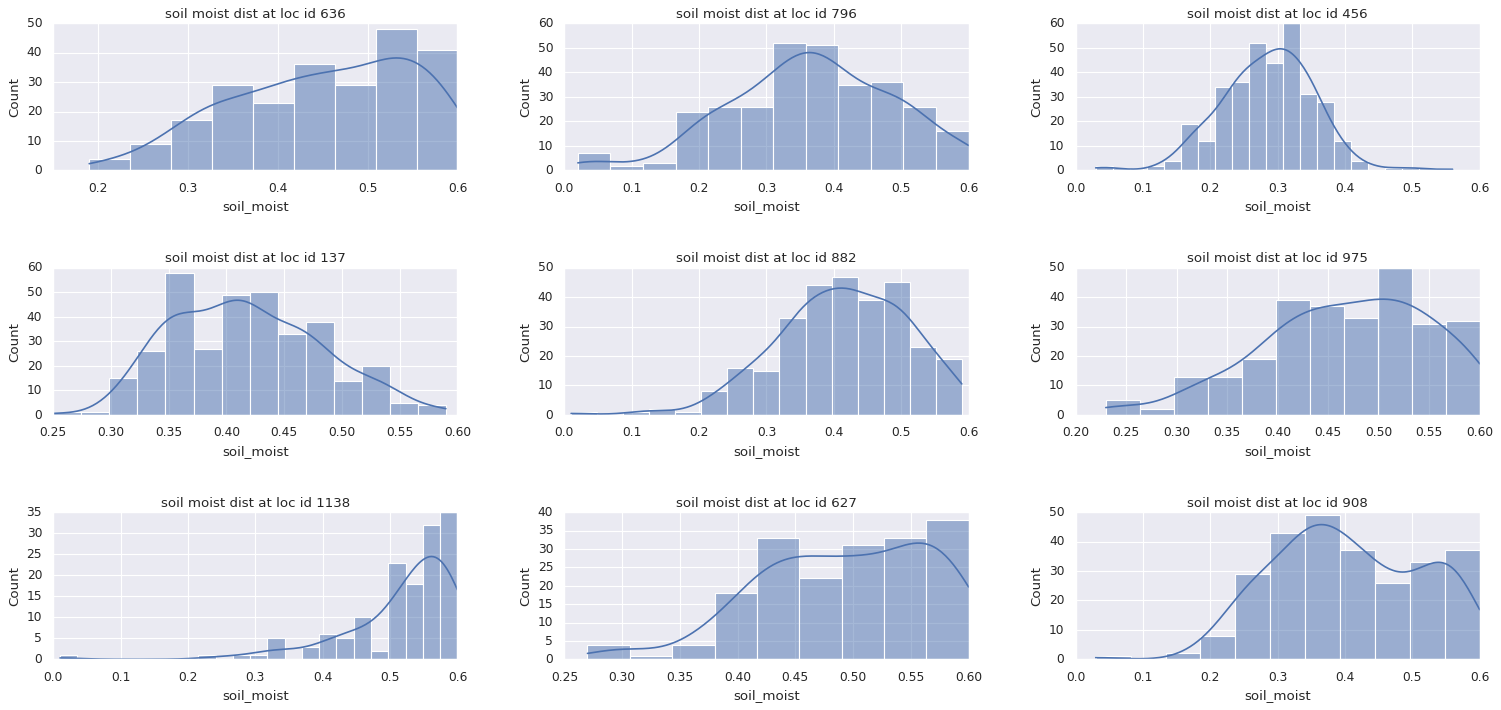

In [70]:
number_of_locs = 9
rand_loc_ids = random.sample(range(1, data['loc'].nunique() + 1), number_of_locs)
fig, axs = plt.subplots(3,3,figsize=(20,10))
fig.tight_layout(pad = 5.0)
loc_idx = 0
for row in range(3):
    for col in range(3):
        loc_data = data[data["loc"]==rand_loc_ids[loc_idx]]
        loc_data.reset_index(inplace=True)
        sns.histplot(data=loc_data,x='soil_moist', kde=True,ax=axs[row][col])
        axs[row][col].set_title(
            f"soil moist dist at loc id {rand_loc_ids[loc_idx]}")
        loc_idx+=1

fig.show()



### Analysis:
By running the random visualization several times we can see that most of the moist distribution are left skewed and normal distribution is in the second place. Regarding this data set is for Europe so that makes sense to be left skewed. 

### Soil Contents Univariate Analysis

Regarding the huge number of samples in data set it is hard to visualize them in a plot, so we can choose 1000 samples randomly and check the relationships. 

In [71]:
soil_cont = ["clay","sand","silt"]
samples_num = 1000
data_subset = data.sample(samples_num)
fig = px.box(data_subset, y= soil_cont, points='all')
fig.show()

In [72]:
fig = px.histogram(data_subset, x= soil_cont)
fig.show()

### Analysis:
Box plots show that there are not any outliers in soil contents values, and the media value of the silt is greater than others.
Histograms show that silt distribution is somehow nearly binomial, sand values are more right skewed and clay has the most similarity to the normal distribution. 

### Bivariate Analysis
I want to check the relation of the contents of the soil and its moisture to see if there is a relationship between them or not.


In [73]:
data.shape

(321584, 8)

In [74]:
for cont in soil_cont:
    fig = px.scatter(data_subset,x=cont, y="soil_moist")
    fig.show()
    

### Analysis:
If the soil content vs moist be plotted several times it is obvious that, any linear relationship can not be observed for any soil contents.

### Correlation Analysis

#### Correlation matrix can be helpful to approve the above assumption about soil contents and soil moisture relation.

<Axes: >

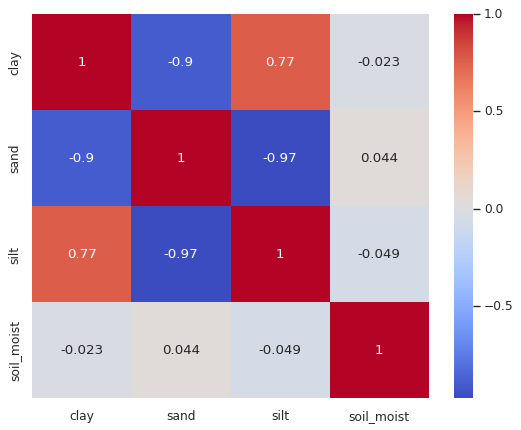

In [75]:
corr_mtx = data_subset[soil_cont+["soil_moist"]].corr()
sns.heatmap(corr_mtx, annot=True, cmap="coolwarm")

In [76]:
corr_mtx["soil_moist"].sort_values(ascending=False)

soil_moist    1.000000
sand          0.043518
clay         -0.023383
silt         -0.048855
Name: soil_moist, dtype: float64

#### Analysis:
 We can see that there is low correlation between soil contents and soil moisture. Sandy soil has positive correlation , clay aprroximaltly zero correlation and silty soils has a negative correlation with the moisture.
 It can be easily observed that there is a high correlation (positive or negative) between soil contents.

## TODO : Soil Content Analysis based on the Locations

## Prediction Model

### The goal is to create a model that can predict the soil moisture in one day. 

In [77]:
start_time = data["time"].min()
end_time = data["time"].max()
print(f"stating date of data set is : {start_time}")
print(f"End date of samples is : {end_time}")

stating date of data set is : 2013-01-01
End date of samples is : 2013-12-31


### Data preparation for Modeling
1) regarding the large values of latitude and longitude we have to scale down the features, so we are going to use max min scaler for the feature scaling.
Firstly we extract the numeric features and then apply the scaler to them.

2) Regarding we are working with time series data set the order of the samples are important, So consider the first 10 months for the training and the last 2 month for testing. If we have data for more than 1 year the training and testing process could be done better, because now nov or dec data can not be used for training
3) Maybe a better approach can be using part of each month for as values for testing. In this case part of data in each season will be used for training and testing.

In [78]:
numeric_feat = data.select_dtypes(exclude="object").columns.tolist()
numeric_feat.remove("loc")
numeric_feat

['latitude', 'longitude', 'clay', 'sand', 'silt', 'soil_moist']

In [79]:
data["time"] = pd.to_datetime(data["time"])

### Hint: We keep the location unscaled for the grouping data by the location id.

In [80]:
mms = MinMaxScaler()
data_sc = data.copy(deep=True)
data_sc[numeric_feat] = mms.fit_transform(data_sc[numeric_feat])
data_sc.head()

,time,latitude,longitude,clay,sand,silt,soil_moist,loc
0,2013-01-03,1.0,0.509091,0.02381,1.0,0.015625,0.881356,1.0
1,2013-01-05,1.0,0.509091,0.02381,1.0,0.015625,0.728814,1.0
2,2013-01-07,1.0,0.509091,0.02381,1.0,0.015625,0.694915,1.0
3,2013-01-08,1.0,0.509091,0.02381,1.0,0.015625,0.915254,1.0
4,2013-01-09,1.0,0.509091,0.02381,1.0,0.015625,0.762712,1.0
